# 评估函数

In [1]:
import evaluate

##### 查看evaluate中可以直接加载的评估函数

In [ ]:
evaluate.list_evaluation_modules(module_type="comparison")

[{'name': 'ncoop57/levenshtein_distance',
  'type': 'comparison',
  'community': True,
  'likes': 0},
 {'name': 'kaleidophon/almost_stochastic_order',
  'type': 'comparison',
  'community': True,
  'likes': 1},
 {'name': 'NeuraFusionAI/Arabic-Evaluation',
  'type': 'comparison',
  'community': True,
  'likes': 0}]

##### 功能一：加载评估函数

In [11]:
accuracy = evaluate.load("accuracy") # 需要联网
accuracy

EvaluationModule(name: "accuracy", module_type: "metric", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = evaluate.load("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
        >>> print(results)
    

In [13]:
print(accuracy.description) # 查看accuracy的说明
print("-" * 50)
print(accuracy.inputs_description) # 查看函数输入的说明


Accuracy is the proportion of correct predictions among the total number of cases processed. It can be computed with:
Accuracy = (TP + TN) / (TP + TN + FP + FN)
 Where:
TP: True positive
TN: True negative
FP: False positive
FN: False negative

--------------------------------------------------

Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = evaluate.load("accuracy")
        >>> res

##### 功能二：计算指标

In [16]:
# 第一种直接给出所有结果进行计算
result = accuracy.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
print(result)

# 第二种迭代添加结果，最后统一计算
for ref, pred in zip([0, 1, 2, 0, 1, 2], [0, 1, 1, 2, 1, 0]):
    accuracy.add(reference=ref, prediction=pred)
result = accuracy.compute()
print(result)

# 第二种扩展，以batch的形式计算
for refs, preds in zip([[0, 1], [2, 0], [1, 2]], [[0, 1], [1, 2], [1, 0]]):
    accuracy.add_batch(references=refs, predictions=preds)
result = accuracy.compute()
print(result)

{'accuracy': 0.5}
{'accuracy': 0.5}
{'accuracy': 0.5}


##### 功能三：多个指标共同计算

In [18]:
combined_metrics = evaluate.combine(["accuracy", "f1", "recall", "precision"])

In [21]:
combined_metrics.compute(references=[0, 1, 0, 0, 1, 0], predictions=[0, 1, 1, 0, 1, 0])

{'accuracy': 0.8333333333333334,
 'f1': 0.8,
 'recall': 1.0,
 'precision': 0.6666666666666666}

##### 功能四：可视化

In [ ]:
from evaluate.visualization import radar_plot

In [23]:
data = [
   {"accuracy": 0.99, "precision": 0.8, "f1": 0.95, "latency_in_seconds": 33.6},
   {"accuracy": 0.98, "precision": 0.87, "f1": 0.91, "latency_in_seconds": 11.2},
   {"accuracy": 0.98, "precision": 0.78, "f1": 0.88, "latency_in_seconds": 87.6}, 
   {"accuracy": 0.88, "precision": 0.78, "f1": 0.81, "latency_in_seconds": 101.6}
   ]
model_names = ["Model 1", "Model 2", "Model 3", "Model 4"]

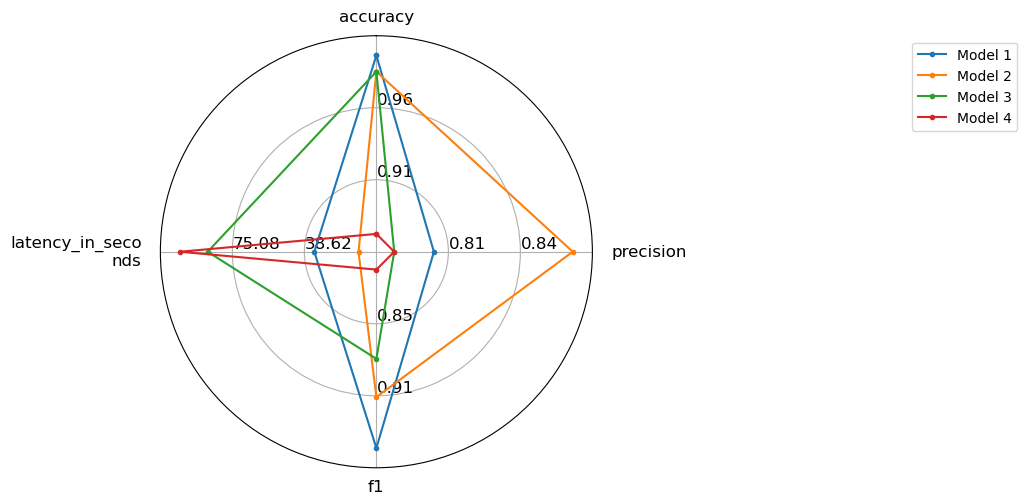

In [24]:
plot = radar_plot(data=data, model_names=model_names)

# 示例

In [57]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

from datasets import load_dataset
import evaluate
import torch

In [58]:
dataset = load_dataset("csv", data_files="../../datas/ChnSentiCorp_htl_all.csv", split="train")

dataset = dataset.filter(lambda x: x["review"] is not None)
dataset = dataset.train_test_split(0.1)

In [59]:
tokenizer = AutoTokenizer.from_pretrained("models/rbt3")

In [60]:
def process_func(examples):
    inputs = tokenizer(examples["review"], max_length=128, truncation=True, padding=True, return_tensors="pt")
    inputs["labels"] = examples["label"]
    return inputs

In [61]:
tokenized_data = dataset.map(process_func, batched=True, remove_columns=dataset["train"].column_names)

Map:   0%|          | 0/6988 [00:00<?, ? examples/s]

Map:   0%|          | 0/777 [00:00<?, ? examples/s]

In [62]:
model = AutoModelForSequenceClassification.from_pretrained("models/rbt3")

if torch.cuda.is_available():
    model = model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at models/rbt3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
from torch.optim import Adam
from torch.utils.data import DataLoader

optimizer = Adam(model.parameters(), lr=2e-5)

In [64]:
trainloader = DataLoader(tokenized_data["train"], batch_size=32, shuffle=True, collate_fn=DataCollatorWithPadding(tokenizer=tokenizer))

testloader = DataLoader(tokenized_data["test"], batch_size=32, shuffle=False, collate_fn=DataCollatorWithPadding(tokenizer=tokenizer))

In [65]:
combined_metrics = evaluate.combine(["accuracy", "f1"])

In [70]:
def train(epoch=3, log_step=100):
    global_step = 0
    for ep in range(1, epoch + 1):
        model.train()

        for batch in trainloader:
            if torch.cuda.is_available():
                batch = {k: v.cuda() for k, v in batch.items()}
            optimizer.zero_grad()
            outputs = model(**batch)
            outputs.loss.backward()
            optimizer.step()

            if global_step % log_step == 0:
                print(f"ep: {ep}, global_step: {global_step}, loss: {outputs.loss.item()}")
            global_step += 1
        
        acc = evaluates()
        print(f"ep: {ep}, acc: {acc}")
    

def evaluates():
    model.eval()
    with torch.inference_mode():
        for batch in testloader:
            if torch.cuda.is_available():
                batch = {k: v.cuda() for k, v in batch.items()}
            outputs = model(**batch).logits.argmax(dim=-1)
            combined_metrics.add_batch(
                references=batch["labels"].long(),
                predictions=outputs.long()
            )
        return combined_metrics.compute()

In [71]:
train()

ep: 1, global_step: 0, loss: 0.7199532389640808
ep: 1, global_step: 100, loss: 0.1860148012638092
ep: 1, global_step: 200, loss: 0.35454803705215454
ep: 1, acc: {'accuracy': 0.8841698841698842, 'f1': 0.9152542372881356}
ep: 2, global_step: 300, loss: 0.30137553811073303
ep: 2, global_step: 400, loss: 0.22547776997089386
ep: 2, acc: {'accuracy': 0.8648648648648649, 'f1': 0.9000951474785919}
ep: 3, global_step: 500, loss: 0.439667671918869
ep: 3, global_step: 600, loss: 0.18847079575061798
ep: 3, acc: {'accuracy': 0.8867438867438867, 'f1': 0.9221238938053097}


In [72]:
from transformers import pipeline

model.config.id2label = {0: "差评", 1: "好评"}
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [ ]:
pipe("这地方有点差劲")

[{'label': '差评', 'score': 0.9694143533706665}]